# Abstract

#### For this project, I am trying to show that various MLB team stats for a season can be used to predict how many games that team won that season. I theorize that this should be possible due to the amount of stats that are collected for each team each season, and the fact that virtually everything that has an impact on the outcome of a game is recorded statistically somewhere. 

#### I used data from baseball reference. For each season, I took 3 tables, one with misc team stats, one with pitching stats, and one with batting stats. I combines all of the stats into one data frame, dropping columns that were not needed, and adding two of my own metrics for each stat, the League Average Difference (LA/D) and the Rank. I then used the backward selection method to fit the model, starting with all the columns and then removing them one at a time.

#### The resulting model has 97.9% of explained variance, and comes within at least 6.32 games of predicting win totals from the testing data, with an average difference of .1 wins per prediction. The average difference being close to 0 is a good sign, and the max difference in predicted and actual wins is 4%

#### In conclusion, I think it is safe to say that this model shows that it is absolutely possible to use team stats from a season to predict how many wins the team won that season. This model is not bad at all, but it could be better. For one, there are so many stats that are collected for baseball, and some of them are not easily available. For another, the model assumes that there are no interaction effects between any of the predictors. The sport is incredibly complex, so it is very possible that some or all of the predictors have an interaction effect with some or all of the other predictors, and one that is difficult to spot. A final concern is that this model by itself cannot be used to predict the future, as it needs stats to be put up in order to predict how many wins a team with those stats should have. However, if combined with a model that predicts player stats for an upcoming season, this model could still be used to predict the win total of a team in a future season. In short, while this model might not be as good as it could possibly be, it is good enough to show that stats can be used to predict wins.

In [2663]:
#Importing packages that I think I will need, and removing the max columns setting for convenience since I need to make sure they are all set up correctly

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 10)
pd.set_option("precision", 5)

In [2603]:
#Creating blank arrays so that I can load the data into them below.

seasons = []
pitching = []
batting = []
seasonsl = []
pitchingl = []
battingl = []

In [2604]:
#Setting the directory to where the data is kept.

pardir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
datadir = pardir + "\\Data"
datadir

'C:\\Users\\Michael\\Desktop\\602\\Homework 1\\Data'

In [2605]:
#Loading the data into three seperate arrays. 
#Since the 4th index is where the three table types first differ in name, that is what I use to seperate them.
#The Miscellaneous Team Info is saved in the seasons array, while the pitching and batting tables are saved in their namesakes.

for f in os.listdir(datadir):
    if f[4] == ".":
        seasons.append(datadir + "\\" + f)
    if f[4] == "W":
        pitching.append(datadir + "\\" + f)
    if f[4] == "B":
        batting.append(datadir + "\\" + f)

In [2606]:
#Reading the files in the arrays, then using the second set of arrays to save the read tables.

for f in seasons:
    seasonsl.append(pd.read_excel(f,0))
for f in pitching:
    pitchingl.append(pd.read_excel(f,0))
for f in batting:
    battingl.append(pd.read_excel(f,0))

In [2607]:
#Inserting a year column in each of the tables.
#The tables do not contain the year column because they are saved one per year, and thus do not need it on their own.
#I do not actually use the year in the model, but I add it to merge on.

i = 1985
for f in seasonsl:
    f.insert(0,"Year", i)
    i+=1

In [2608]:
i = 1985
for f in pitchingl:
    f.insert(0,"Year", i)
    i+=1

In [2609]:
i = 1985
for f in battingl:
    f.insert(0,"Year", i)
    i+=1

In [2610]:
#Dropping columns that will not be useful from the Miscellaneous Team Info table. 
#For example, game time should not matter because no matter the length of the game, one team wins and one team loses.
##HOF should not matter because it can only be known years later and thus is not accurate more recently anyway.
#Who the manager is could matter, but the theory is that whatever it is they do to win more or less should show in other stats.

for f in seasonsl:
    f.drop(columns = ['Time', '#HOF', '#A-S', '#a-tA-S', 'Managers', 'BPF', 'PPF'], inplace = True)
#The following 3 columns are not in all of the years, as it was not tracked until recently.
#Not only can it thus not be used, but it makes it more difficult to remove them than the ones above.
    try:
        f.drop(columns = ['Chall', 'Succ', "Succ%"], inplace = True)
        print("Successfully removed")
    except:
        print("These columns are not present")

These columns are not present
These columns are not present
These columns are not present
These columns are not present
These columns are not present
These columns are not present
These columns are not present
These columns are not present
These columns are not present
These columns are not present
These columns are not present
These columns are not present
These columns are not present
These columns are not present
These columns are not present
These columns are not present
These columns are not present
These columns are not present
These columns are not present
These columns are not present
These columns are not present
These columns are not present
These columns are not present
These columns are not present
These columns are not present
These columns are not present
These columns are not present
These columns are not present
These columns are not present
Successfully removed
Successfully removed
Successfully removed
Successfully removed
Successfully removed
Successfully removed


In [2612]:
#Adding new columns to the data.
#The first new metric being added here is League Average Difference (LA/D), or the difference between the stat and the league average of that stat.
#For example, if a team hit 158 home runs, and the league average that year was 160, the (LA/D) for home runs for that team would be -2.
#The reasoning behind this metric is that the raw stats fluctuate every year. Some years a team can lead all of baseball with one number, and be middle of the pack another year, even with more in that stat than when they led.
#Thus, the theory is that what matters is not the raw number, but how many more or less than the average for that season.
#Since there is no league average row, I create a sum row for each column, and then divide that by the number of teams for that season.
#It  adds the metric at the index after the base column for each metric.

for f in seasonsl:
    f.loc[len(f.index)] = f.sum()
    j = len(f.axes[1])
    for i in range(2,j+4,2):
        f.insert(i+1, '(LA/D)' + f.columns[i], (f.iloc[-1][i])/(len(f.index)-1))
        f[f.columns[i+1]] = f[f.columns[i]] - f[f.columns[i+1]]
        j+=1

In [2613]:
#Adding the second metric for each base metric, Rank.
#The idea behind this metric is that like with (LA/D), the raw stats can be misleading.
#However, instead of finding the raw amount more or less than average, the Rank metric simply ranks the teams from first to last in that stat.
#So, for example, instead of giving a -2 (LA/D) for home runs in the above example, it might return that the team was 20th out of 30.
#The stat is inverted from normal rankings, so if a team is 1st out of 28 teams, the Rank would be 28. If a team was ranked last, the Rank would be 1.

for f in seasonsl:
    j = len(f.axes[1])
    f.drop(len(f.axes[0])-1, inplace = True)
    for i in range(2,j+4,3):
        f.insert(i+2, f.columns[i] + 'Rank', f[f.columns[i]].rank(method='max'))
        j+=1

In [2614]:
#The most recent season, to check everything created properly.

seasonsl[-1]

,Year,Tm,Attendance,(LA/D)Attendance,AttendanceRank,Attend/G,(LA/D)Attend/G,Attend/GRank,BatAge,(LA/D)BatAge,BatAgeRank,PAge,(LA/D)PAge,PAgeRank,Est. Payroll,(LA/D)Est. Payroll,Est. PayrollRank
0,2019,ARI,2135510,-147648.4,14.0,26364,-1831.66667,14.0,28.7,0.77333,24.0,28.6,0.21667,21.0,124016266,-9.31130e+06,14.0
1,2019,ATL,2655100,371941.6,19.0,32779,4583.33333,19.0,28.0,0.07333,19.0,27.5,-0.88333,7.0,133186667,-1.40902e+05,17.0
2,2019,BAL,1307807,-975351.4,3.0,16146,-12049.66667,3.0,26.5,-1.42667,3.0,27.3,-1.08333,6.0,82696100,-5.06315e+07,6.0
3,2019,BOS,2924627,641468.6,24.0,36107,7911.33333,24.0,27.3,-0.62667,5.0,29.0,0.61667,25.0,218978142,8.56506e+07,29.0
4,2019,CHC,3094865,811706.6,27.0,38208,10012.33333,27.0,27.7,-0.22667,11.0,31.1,2.71667,30.0,217805215,8.44776e+07,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,2019,STL,3480393,1197234.6,29.0,42968,14772.33333,29.0,28.8,0.87333,27.0,27.8,-0.58333,11.0,161120267,2.77927e+07,22.0
26,2019,TBR,1178735,-1104423.4,2.0,14552,-13643.66667,2.0,27.2,-0.72667,4.0,27.8,-0.58333,11.0,56071767,-7.72558e+07,1.0
27,2019,TEX,2132994,-150164.4,13.0,26333,-1862.66667,13.0,28.8,0.87333,27.0,28.3,-0.08333,17.0,104433499,-2.88941e+07,11.0
28,2019,TOR,1750144,-533014.4,10.0,21607,-6588.66667,10.0,25.9,-2.02667,1.0,28.0,-0.38333,13.0,64680671,-6.86469e+07,2.0


In [2615]:
#Dropping columns that will not be needed from the pitching table.
#Pitcher age is already included in the above table and is not needed again.
#Games started is the same as games played, and games finished is simply games where the team did not win in a walk-off.
#Losses and Win-Loss Percentage are not needed, as the target metric is wins. 
#For whatever reason, the league average for tSho and cSho is not recorded properly, so the last two lines fix that.

for f in pitchingl:
    f.drop(columns = ['PAge', 'GS', 'GF','L','W-L%'], inplace = True)
    f.drop(len(f.axes[0])-1, inplace = True)
    f.loc[26, "tSho"] = float(f['tSho'].sum()/((len(f.axes[0])-1)))
    f.loc[26, "cSho"] = float(f['cSho'].sum()/((len(f.axes[0])-1)))

In [2616]:
#Adding the (LA/D) metric to the pitching tables.

for f in pitchingl:
    j = len(f.axes[1])
    for i in range(2,j+29,2):
        f.insert(i+1, '(LA/D)' + f.columns[i], (f.iloc[-1][i]))
        f[f.columns[i+1]] = f[f.columns[i]] - f[f.columns[i+1]]
        j+=1

In [2617]:
#Addomg the Rank metric to the pitching tables.

for f in pitchingl:
    j = len(f.axes[1])
    f.drop(len(f.axes[0])-1, inplace = True)
    for i in range(2,j+29,3):
        f.insert(i+2, f.columns[i] + 'Rank', f[f.columns[i]].rank(method='max'))
        j+=1

In [2618]:
#Checking the first season of the pitching table.

pitchingl[0]

,Year,Tm,#P,(LA/D)#P,#PRank,RA/G,(LA/D)RA/G,RA/GRank,W,(LA/D)W,WRank,ERA,(LA/D)ERA,ERARank,G,(LA/D)G,GRank,CG,(LA/D)CG,CGRank,tSho,(LA/D)tSho,tShoRank,cSho,(LA/D)cSho,cShoRank,SV,(LA/D)SV,SVRank,IP,(LA/D)IP,IPRank,H,(LA/D)H,HRank,R,(LA/D)R,RRank,ER,(LA/D)ER,ERRank,HR,(LA/D)HR,HRRank,BB,(LA/D)BB,BBRank,IBB,(LA/D)IBB,IBBRank,SO,(LA/D)SO,SORank,HBP,(LA/D)HBP,HBPRank,BK,(LA/D)BK,BKRank,WP,(LA/D)WP,WPRank,BF,(LA/D)BF,BFRank,ERA+,(LA/D)ERA+,ERA+Rank,FIP,(LA/D)FIP,FIPRank,WHIP,(LA/D)WHIP,WHIPRank,H9,(LA/D)H9,H9Rank,HR9,(LA/D)HR9,HR9Rank,BB9,(LA/D)BB9,BB9Rank,SO9,(LA/D)SO9,SO9Rank,SO/W,(LA/D)SO/W,SO/WRank,LOB,(LA/D)LOB,LOBRank
0,1985,ATL,14,-2,4.0,4.82,0.49,20.0,66,-15,5.0,4.19,0.30,19.0,162,0,24.0,9,-15,1.0,9.0,-0.88462,18.0,3.0,-3.26923,6.0,29,-9,5.0,1457.1,9.1,20.0,1512,97,25.0,781,80,20.0,679,53,19.0,134,-5,13.0,642,110,26.0,83,32,26.0,776,-88,5.0,28,1,18.0,4,-5,3.0,35,-9,8.0,6374,208,26.0,91,-9,5.0,4.19,0.30,19.0,1.478,0.134,25.0,9.3,0.5,23.0,0.8,-0.1,13.0,4.0,0.7,26.0,4.8,-0.6,5.0,1.21,-0.41,1.0,1221,101,25.0
1,1985,BAL,15,-1,9.0,4.75,0.42,19.0,83,2,15.0,4.38,0.49,20.0,161,-1,8.0,32,8,21.0,6.0,-3.88462,6.0,6.0,-0.26923,18.0,33,-5,9.0,1427.1,-20.9,4.0,1480,65,21.0,764,63,19.0,694,68,20.0,160,21,19.0,568,36,19.0,57,6,17.0,793,-71,8.0,23,-4,9.0,7,-2,13.0,32,-12,3.0,6182,16,15.0,92,-8,6.0,4.27,0.38,22.0,1.435,0.091,23.0,9.3,0.5,23.0,1.0,0.1,21.0,3.6,0.3,22.0,5.0,-0.4,9.0,1.40,-0.22,5.0,1136,16,15.0
2,1985,BOS,17,1,18.0,4.42,0.09,17.0,81,0,12.0,4.06,0.17,16.0,163,1,26.0,35,11,23.0,8.0,-1.88462,13.0,5.0,-1.26923,14.0,29,-9,5.0,1461.1,13.1,23.0,1487,72,22.0,720,19,17.0,659,33,17.0,130,-9,11.0,540,8,15.0,54,3,15.0,913,49,20.0,35,8,22.0,13,4,22.0,34,-10,7.0,6281,115,24.0,106,6,17.0,3.77,-0.12,11.0,1.387,0.043,17.0,9.2,0.4,19.0,0.8,-0.1,13.0,3.3,0.0,15.0,5.6,0.2,19.0,1.69,0.07,14.0,1177,57,23.0
3,1985,CAL,19,3,22.0,4.34,0.01,14.0,90,9,20.0,3.91,0.02,14.0,162,0,24.0,22,-2,11.0,8.0,-1.88462,13.0,5.0,-1.26923,14.0,41,3,18.0,1457.1,9.1,20.0,1453,38,17.0,703,2,14.0,633,7,14.0,171,32,23.0,514,-18,10.0,30,-21,3.0,767,-97,4.0,27,0,15.0,4,-5,3.0,45,1,15.0,6164,-2,12.0,107,7,19.0,4.27,0.38,22.0,1.350,0.006,13.0,9.0,0.2,17.0,1.1,0.2,26.0,3.2,-0.1,13.0,4.7,-0.7,3.0,1.49,-0.13,6.0,1089,-31,9.0
4,1985,CHC,20,4,25.0,4.50,0.17,18.0,77,-4,11.0,4.16,0.27,18.0,162,0,24.0,20,-4,10.0,8.0,-1.88462,13.0,6.0,-0.26923,18.0,42,4,20.0,1442.1,-5.9,8.0,1492,77,23.0,729,28,18.0,666,40,18.0,156,17,17.0,519,-13,13.0,83,32,26.0,820,-44,10.0,23,-4,9.0,11,2,20.0,31,-13,2.0,6195,29,17.0,95,-5,10.0,4.08,0.19,17.0,1.394,0.050,18.0,9.3,0.5,23.0,1.0,0.1,21.0,3.2,-0.1,13.0,5.1,-0.3,11.0,1.58,-0.04,9.0,1139,19,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21,1985,SEA,21,5,26.0,5.05,0.72,25.0,74,-7,7.0,4.68,0.79,25.0,162,0,24.0,23,-1,12.0,8.0,-1.88462,13.0,5.0,-1.26923,14.0,30,-8,7.0,1432.0,-16.0,5.0,1456,41,18.0,818,117,25.0,744,118,25.0,154,15,16.0,637,105,25.0,54,3,15.0,868,4,14.0,41,14,25.0,18,9,26.0,61,17,24.0,6260,94,22.0,90,-10,3.0,4.29,0.40,23.0,1.462,0.118,24.0,9.2,0.4,19.0,1.0,0.1,21.0,4.0,0.7,26.0,5.5,0.1,15.0,1.36,-0.26,4.0,1146,26,20.0
22,1985,SFG,15,-1,9.0,4.16,-0.17,11.0,62,-19,4.0,3.61,-0.28,8.0,162,0,24.0,13,-11,4.0,5.0,-4.88462,3.0,4.0,-2.26923,7.0,24,-14,1.0,1448.0,0.0,12.0,1348,-67,8.0,674,-27,11.0,581,-45,8.0,125,-14,9.0,572,40,21.0,76,25,23.0,985,121,24.0,19,-8,4.0,16,7,25.0,57,13,23.0,6168,2,14.0,96,-4,11.0,3.67,-0.22,8.0,1.326,-0.018,11.0,8.4,-0.4,8.0,0.8,-0.1,13.0,3.6,0.3,22.0,6.1,0.7,24.0,1.72,0.10,20.0,1150,30,21.0
23,1985,STL,16,0,11.0,3.53,-0.80,2.0,101,20,26.0,3.10,-0.79,2.0,162,0,24.0,37,13,25.0,20.0,10.11538,25.0,17.0,10.73077,26.0,44,6,22.0,1464.0,16.0,24.0,1343,-72,5.0,572,-129,2.0,505,-121,2.0,98,-41,1.0,453,-79,2.0,80,29

In [2619]:
#Dropping the Batter Age and Games columns as they are included in the Misc and Pitching tables respectively.

for f in battingl:
    f.drop(columns = ['BatAge', 'G'], inplace = True)
    f.drop(len(f.axes[0])-1, inplace = True)

In [2620]:
#Adding the (LA/D) metric to the batting tables.

for f in battingl:
    j = len(f.axes[1])
    for i in range(2,j+25,2):
        f.insert(i+1, '(LA/D)' + f.columns[i], (f.iloc[-1][i]))
        f[f.columns[i+1]] = f[f.columns[i]] - f[f.columns[i+1]]
        j+=1

In [2621]:
#Adding the Rank metric to the batting tables.

for f in battingl:
    j = len(f.axes[1])
    f.drop(len(f.axes[0])-1, inplace = True)
    for i in range(2,j+25,3):
        f.insert(i+2, f.columns[i] + 'Rank', f[f.columns[i]].rank(method='max'))
        j+=1

In [2622]:
#Checking a batting table.

battingl[29]

,Year,Tm,#Bat,(LA/D)#Bat,#BatRank,R/G,(LA/D)R/G,R/GRank,PA,(LA/D)PA,PARank,AB,(LA/D)AB,ABRank,R,(LA/D)R,RRank,H,(LA/D)H,HRank,2B,(LA/D)2B,2BRank,3B,(LA/D)3B,3BRank,HR,(LA/D)HR,HRRank,RBI,(LA/D)RBI,RBIRank,SB,(LA/D)SB,SBRank,CS,(LA/D)CS,CSRank,BB,(LA/D)BB,BBRank,SO,(LA/D)SO,SORank,BA,(LA/D)BA,BARank,OBP,(LA/D)OBP,OBPRank,SLG,(LA/D)SLG,SLGRank,OPS,(LA/D)OPS,OPSRank,OPS+,(LA/D)OPS+,OPS+Rank,TB,(LA/D)TB,TBRank,GDP,(LA/D)GDP,GDPRank,HBP,(LA/D)HBP,HBPRank,SH,(LA/D)SH,SHRank,SF,(LA/D)SF,SFRank,IBB,(LA/D)IBB,IBBRank,LOB,(LA/D)LOB,LOBRank
0,2014,ARI,52,8,25.0,3.80,-0.27,6.0,6089,-42,13.0,5552,32,22.0,615,-44,6.0,1379,-8,15.0,259,-12,11.0,47,19,30.0,118,-22,6.0,573,-52,4.0,86,-6,13.0,33,-2,14.0,398,-69,4.0,1165,-83,9.0,0.248,-0.003,13.0,0.302,-0.012,6.0,0.376,-0.010,12.0,0.678,-0.022,7.0,88,-9,5.0,2086,-47,13.0,115,-5,12.0,43,-12,7.0,56,11,21.0,36,-7,6.0,31,-2,16.0,1092,-19,12.0
1,2014,ATL,39,-5,1.0,3.54,-0.53,2.0,6064,-67,7.0,5468,-52,8.0,573,-86,2.0,1316,-71,5.0,240,-31,3.0,22,-6,7.0,123,-17,9.0,545,-80,2.0,95,3,15.0,33,-2,14.0,472,5,17.0,1369,121,27.0,0.241,-0.010,5.0,0.305,-0.009,7.0,0.360,-0.026,2.0,0.665,-0.035,4.0,88,-9,5.0,1969,-164,3.0,121,1,17.0,43,-12,7.0,53,8,18.0,27,-16,1.0,31,-2,16.0,1128,17,19.0
2,2014,BAL,44,0,7.0,4.35,0.28,23.0,6130,-1,15.0,5596,76,26.0,705,46,23.0,1434,47,23.0,264,-7,14.0,16,-12,1.0,211,71,30.0,681,56,24.0,44,-48,1.0,20,-15,2.0,401,-66,5.0,1285,37,20.0,0.256,0.005,23.0,0.311,-0.003,14.0,0.422,0.036,28.0,0.734,0.034,26.0,104,7,25.0,2363,230,28.0,112,-8,9.0,62,7,25.0,35,-10,12.0,36,-7,6.0,29,-4,12.0,1088,-23,11.0
3,2014,BOS,55,11,28.0,3.91,-0.16,13.0,6226,95,26.0,5551,31,21.0,634,-25,13.0,1355,-32,10.0,282,11,22.0,20,-8,5.0,123,-17,9.0,601,-24,13.0,63,-29,6.0,25,-10,6.0,535,68,28.0,1337,89,25.0,0.244,-0.007,10.0,0.316,0.002,17.0,0.369,-0.017,8.0,0.684,-0.016,10.0,91,-6,7.0,2046,-87,8.0,138,18,27.0,68,13,27.0,20,-25,3.0,52,9,27.0,36,3,21.0,1168,57,27.0
4,2014,CHC,48,4,20.0,3.79,-0.28,5.0,6102,-29,14.0,5508,-12,11.0,614,-45,5.0,1315,-72,4.0,270,-1,16.0,31,3,22.0,157,17,26.0,590,-35,8.0,65,-27,7.0,40,5,22.0,442,-25,11.0,1477,229,30.0,0.239,-0.012,4.0,0.300,-0.014,4.0,0.385,-0.001,17.0,0.684,-0.016,10.0,89,-8,6.0,2118,-15,17.0,94,-26,3.0,54,-1,15.0,57,12,22.0,41,-2,15.0,29,-4,12.0,1069,-42,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,2014,STL,46,2,15.0,3.82,-0.25,8.0,6086,-45,11.0,5426,-94,3.0,619,-40,8.0,1371,-16,14.0,275,4,19.0,21,-7,6.0,105,-35,2.0,585,-40,6.0,57,-35,3.0,32,-3,12.0,471,4,16.0,1133,-115,5.0,0.253,0.002,19.0,0.320,0.006,22.0,0.369,-0.017,8.0,0.689,-0.011,13.0,93,-4,11.0,2003,-130,5.0,140,20,28.0,86,31,30.0,64,19,27.0,39,-4,12.0,28,-5,8.0,1145,34,21.0
26,2014,TBR,43,-1,4.0,3.78,-0.29,4.0,6205,74,22.0,5516,-4,12.0,612,-47,4.0,1361,-26,12.0,263,-8,13.0,24,-4,10.0,117,-23,5.0,586,-39,7.0,63,-29,6.0,27,-8,11.0,527,60,27.0,1124,-124,3.0,0.247,-0.004,12.0,0.317,0.003,20.0,0.367,-0.019,6.0,0.684,-0.016,10.0,96,-1,18.0,2023,-110,6.0,135,15,25.0,66,11,26.0,43,-2,14.0,53,10,28.0,31,-2,16.0,1193,82,30.0
27,2014,TEX,64,20,30.0,3.93,-0.14,14.0,6026,-105,4.0,5460,-60,6.0,637,-22,14.0,1400,13,18.0,260,-11,12.0,28,0,17.0,111,-29,4.0,597,-28,11.0,105,13,23.0,59,24,30.0,417,-50,8.0,1162,-86,8.0,0.256,0.005,23.0,0.314,0.000,16.0,0.375,-0.011,9.0,0.689,-0.011,13.0,92,-5,9.0,2049,-84,10.0,148,28,30.0,61,6,24.0,41,-4,13.0,45,2,21.0,37,4,23.0,1066,-45,5.0
28,2014,TOR,55,11,28.0,4.46,0.39,26.0,6167,36,18.0,5549,29,20.0,723,64,26.0,1435,48,24.0,282,11,22.0,24,-4,10.0,177,37,28.0,690,65,27.0,78,-14,8.0,21,-14,4.0,502,35,21.0,1151,-97,7.0,0.259,0.008,26.0,0.323,0.009,25.0,0.414,0.028,27.0,0.736,0.036,27.0,108,11,27.0,2296,163,27.0,128,8,22.0,41,-14,3.0,35,-10,12.0,40,-3,13.0,27,-6,7.0,1122,11,17.0


In [2623]:
#The number of columns in the first entry in the table, to see how many columns there are.

len(battingl[0].axes[1])

80

In [2624]:
#Combining the tables on both the year and team columns, to match up the data from all 3 tables for each year.

combined = []
i = 0
for f in seasonsl:
    combined.append(f.merge(pitchingl[i], how='inner', on=["Year","Tm"]).merge(battingl[i], how='inner', on=["Year","Tm"]))
    i+=1

In [2625]:
#The combined table, checking a season to see that everything combined correctly.

combined[27]

,Year,Tm,Attendance,(LA/D)Attendance,AttendanceRank,Attend/G,(LA/D)Attend/G,Attend/GRank,BatAge,(LA/D)BatAge,BatAgeRank,PAge,(LA/D)PAge,PAgeRank,Est. Payroll,(LA/D)Est. Payroll,Est. PayrollRank,#P,(LA/D)#P,#PRank,RA/G,(LA/D)RA/G,RA/GRank,W,(LA/D)W,WRank,ERA,(LA/D)ERA,ERARank,G,(LA/D)G,GRank,CG,(LA/D)CG,CGRank,tSho,(LA/D)tSho,tShoRank,cSho,(LA/D)cSho,cShoRank,SV,(LA/D)SV,SVRank,IP,(LA/D)IP,IPRank,H_x,(LA/D)H_x,HRank_x,R_x,(LA/D)R_x,RRank_x,ER,(LA/D)ER,ERRank,HR_x,(LA/D)HR_x,HRRank_x,BB_x,(LA/D)BB_x,BBRank_x,IBB_x,(LA/D)IBB_x,IBBRank_x,SO_x,(LA/D)SO_x,SORank_x,HBP_x,(LA/D)HBP_x,HBPRank_x,BK,(LA/D)BK,BKRank,WP,(LA/D)WP,WPRank,BF,(LA/D)BF,BFRank,ERA+,(LA/D)ERA+,ERA+Rank,FIP,(LA/D)FIP,FIPRank,WHIP,(LA/D)WHIP,WHIPRank,H9,(LA/D)H9,H9Rank,HR9,(LA/D)HR9,HR9Rank,BB9,(LA/D)BB9,BB9Rank,SO9,(LA/D)SO9,SO9Rank,SO/W,(LA/D)SO/W,SO/WRank,LOB_x,(LA/D)LOB_x,LOBRank_x,#Bat,(LA/D)#Bat,#BatRank,R/G,(LA/D)R/G,R/GRank,PA,(LA/D)PA,PARank,AB,(LA/D)AB,ABRank,R_y,(LA/D)R_y,RRank_y,H_y,(LA/D)H_y,HRank_y,2B,(LA/D)2B,2BRank,3B,(LA/D)3B,3BRank,HR_y,(LA/D)HR_y,HRRank_y,RBI,(LA/D)RBI,RBIRank,SB,(LA/D)SB,SBRank,CS,(LA/D)CS,CSRank,BB_y,(LA/D)BB_y,BBRank_y,SO_y,(LA/D)SO_y,SORank_y,BA,(LA/D)BA,BARank,OBP,(LA/D)OBP,OBPRank,SLG,(LA/D)SLG,SLGRank,OPS,(LA/D)OPS,OPSRank,OPS+,(LA/D)OPS+,OPS+Rank,TB,(LA/D)TB,TBRank,GDP,(LA/D)GDP,GDPRank,HBP_y,(LA/D)HBP_y,HBPRank_y,SH,(LA/D)SH,SHRank,SF,(LA/D)SF,SFRank,IBB_y,(LA/D)IBB_y,IBBRank_y,LOB_y,(LA/D)LOB_y,LOBRank_y
0,2012,ARI,2177617,-317691.93333,12.0,26884,-3922.33333,12.0,28.3,-0.22667,17.0,27.4,-0.96667,5.0,67069833,-3.12666e+07,6.0,23,1,12.0,4.25,-0.07,15.0,81,0,15.0,3.93,-0.08,15.0,162,0,30.0,4,0,15.0,9.00000,NaN,11.0,2.0,NaN,19.0,39,-3,11.0,1433.2,-11.8,7.0,1432,30,20.0,688,-13,15.0,626,-17,14.0,155,-9,12.0,417,-73,2.0,18,-17,2.0,1200,-14,15.0,51,1,20.0,10,4,29.0,52,1,16.0,6063,-76,7.0,104,3,18.0,3.81,-0.20,10.0,1.290,-0.019,15.0,9.0,0.3,25.0,1.0,0.0,17.0,2.6,-0.5,3.0,7.5,-0.1,16.0,2.88,0.40,25.0,1074,-29,9.0,48,5,18.0,4.53,0.21,23.0,6150,11,17.0,5462,-46,10.0,734,33,23.0,1416,14,18.0,307,32,29.0,33,2,20.0,165,1,17.0,710,43,23.0,93,-15,9.0,51,13,29.0,539,49,25.0,1266,52,23.0,0.259,0.004,19.0,0.328,0.009,24.0,0.418,0.013,21.0,0.746,0.022,22.0,99,2,22.0,2284,51,19.0,108,-12,8.0,41,-9,7.0,61,12,20.0,45,4,23.0,47,12,28.0,1122,19,20.0
1,2012,ATL,2420171,-75137.93333,17.0,29879,-927.33333,17.0,28.5,-0.02667,18.0,27.6,-0.76667,9.0,86208000,-1.21284e+07,15.0,21,-1,7.0,3.70,-0.62,5.0,94,13,27.0,3.42,-0.59,5.0,162,0,30.0,5,1,20.0,16.00000,NaN,30.0,4.0,NaN,27.0,47,5,24.0,1445.1,0.1,17.0,1310,-92,4.0,600,-101,5.0,549,-94,5.0,145,-19,7.0,464,-26,10.0,40,5,23.0,1232,18,18.0,41,-9,5.0,3,-3,7.0,54,3,20.0,5991,-148,1.0,117,16,27.0,3.74,-0.27,8.0,1.227,-0.082,4.0,8.2,-0.5,4.0,0.9,-0.1,10.0,2.9,-0.2,13.0,7.7,0.1,20.0,2.66,0.18,20.0,1055,-48,6.0,41,-2,4.0,4.32,0.00,14.0,6126,-13,15.0,5425,-83,6.0,700,-1,14.0,1341,-61,9.0,263,-12,8.0,30,-1,17.0,149,-15,12.0,660,-7,13.0,101,-7,13.0,32,-6,8.0,567,77,29.0,1289,75,24.0,0.247,-0.008,11.0,0.320,0.001,18.0,0.389,-0.016,9.0,0.709,-0.015,10.0,90,-7,5.0,2111,-122,9.0,108,-12,8.0,34,-16,3.0,53,4,17.0,46,5,24.0,37,2,19.0,1127,24,22.0
2,2012,BAL,2102240,-393068.93333,10.0,25954,-4852.33333,10.0,28.0,-0.52667,14.0,27.6,-0.76667,9.0,77949000,-2.03874e+07,9.0,26,4,25.0,4.35,0.03,17.0,93,12,24.0,3.90,-0.11,14.0,162,0,30.0,1,-3,5.0,10.00000,NaN,16.0,1.0,NaN,10.0,55,13,29.0,1483.0,38.0,30.0,1433,31,21.0,705,4,17.0,642,-1,18.0,184,20,23.0,481,-9,13.0,36,1,20.0,1177,-37,13.0,53,3,21.0,6,0,21.0,34,-17,3.0,6278,139,28.0,109,8,22.0,4.20,0.19,21.0,1.291,-0.018,17.0,8.7,0.0,18.0,1.1,0.1,23.0,2.9,-0.2,13.0,7.1,-0.5,6.0,2.45,-0.03,14.0,1124,21,21.0,52,9,26.0,4.40,0.08,17.0,6160,21,18.0,5560,52,23.0,712,11,16.0,1375,-27,13.0,270,-5,14.0,16,-15,3.0,214,50,29.0,677,10,19.0,58,-50,1.0,29,-9,5.0,480,-10,15.0,1315,101,25.0,0.247,-0.008,11.0,0.311,-0.008,8.0,0.417,0.012,20.0,0.728,0.004,19.0,97,0,16.0,2319,86,21.0,152,32,29.0,50,0,15.0,38,-11,13.0,30,-11,4.0,24,-11,4.0,1027,-76,2.0
3,2012,BOS,3043003,547694.06667,23.0,37568,6761

In [2626]:
#Combining all the seasons to one data frame.

finalframe = pd.concat(combined, ignore_index=True)
finalframe

,Year,Tm,Attendance,(LA/D)Attendance,AttendanceRank,Attend/G,(LA/D)Attend/G,Attend/GRank,BatAge,(LA/D)BatAge,BatAgeRank,PAge,(LA/D)PAge,PAgeRank,Est. Payroll,(LA/D)Est. Payroll,Est. PayrollRank,#P,(LA/D)#P,#PRank,RA/G,(LA/D)RA/G,RA/GRank,W,(LA/D)W,WRank,ERA,(LA/D)ERA,ERARank,G,(LA/D)G,GRank,CG,(LA/D)CG,CGRank,tSho,(LA/D)tSho,tShoRank,cSho,(LA/D)cSho,cShoRank,SV,(LA/D)SV,SVRank,IP,(LA/D)IP,IPRank,H_x,(LA/D)H_x,HRank_x,R_x,(LA/D)R_x,RRank_x,ER,(LA/D)ER,ERRank,HR_x,(LA/D)HR_x,HRRank_x,BB_x,(LA/D)BB_x,BBRank_x,IBB_x,(LA/D)IBB_x,IBBRank_x,SO_x,(LA/D)SO_x,SORank_x,HBP_x,(LA/D)HBP_x,HBPRank_x,BK,(LA/D)BK,BKRank,WP,(LA/D)WP,WPRank,BF,(LA/D)BF,BFRank,ERA+,(LA/D)ERA+,ERA+Rank,FIP,(LA/D)FIP,FIPRank,WHIP,(LA/D)WHIP,WHIPRank,H9,(LA/D)H9,H9Rank,HR9,(LA/D)HR9,HR9Rank,BB9,(LA/D)BB9,BB9Rank,SO9,(LA/D)SO9,SO9Rank,SO/W,(LA/D)SO/W,SO/WRank,LOB_x,(LA/D)LOB_x,LOBRank_x,#Bat,(LA/D)#Bat,#BatRank,R/G,(LA/D)R/G,R/GRank,PA,(LA/D)PA,PARank,AB,(LA/D)AB,ABRank,R_y,(LA/D)R_y,RRank_y,H_y,(LA/D)H_y,HRank_y,2B,(LA/D)2B,2BRank,3B,(LA/D)3B,3BRank,HR_y,(LA/D)HR_y,HRRank_y,RBI,(LA/D)RBI,RBIRank,SB,(LA/D)SB,SBRank,CS,(LA/D)CS,CSRank,BB_y,(LA/D)BB_y,BBRank_y,SO_y,(LA/D)SO_y,SORank_y,BA,(LA/D)BA,BARank,OBP,(LA/D)OBP,OBPRank,SLG,(LA/D)SLG,SLGRank,OPS,(LA/D)OPS,OPSRank,OPS+,(LA/D)OPS+,OPS+Rank,TB,(LA/D)TB,TBRank,GDP,(LA/D)GDP,GDPRank,HBP_y,(LA/D)HBP_y,HBPRank_y,SH,(LA/D)SH,SHRank,SF,(LA/D)SF,SFRank,IBB_y,(LA/D)IBB_y,IBBRank_y,LOB_y,(LA/D)LOB_y,LOBRank_y
0,1985,ATL,1350137,-4.50801e+05,8.0,16668,-5606.15385,7.0,28.1,-0.75385,12.0,28.8,0.47308,16.0,14807000,4.61602e+06,26.0,14,-2,4.0,4.82,0.49,20.0,66,-15,5.0,4.19,0.30,19.0,162,0,24.0,9,-15,1.0,9.00000,-0.88462,18.0,3.00000,-3.26923,6.0,29,-9,5.0,1457.1,9.1,20.0,1512,97,25.0,781,80,20.0,679,53,19.0,134,-5,13.0,642,110,26.0,83,32,26.0,776,-88,5.0,28,1,18.0,4,-5,3.0,35,-9,8.0,6374,208,26.0,91,-9,5.0,4.19,0.30,19.0,1.478,0.134,25.0,9.3,0.5,23.0,0.8,-0.1,13.0,4.0,0.7,26.0,4.8,-0.6,5.0,1.21,-0.41,1.0,1221,101,25.0,33,-3,2.0,3.90,-0.43,4.0,6208,42,18.0,5526,23,19.0,632,-69,4.0,1359,-56,6.0,213,-34,2.0,28,-9,6.0,126,-13,10.0,598,-61,5.0,72,-47,6.0,52,-3,12.0,553,21,18.0,849,-15,13.0,0.246,-0.011,3.0,0.315,-0.008,7.0,0.363,-0.028,3.0,0.678,-0.036,3.0,86,-11,3.0,2006,-145,3.0,154,27,25.0,22,-5,9.0,65,5,16.0,41,-3,10.0,56,5,16.0,1163,43,23.0
1,1985,BAL,2132387,3.31449e+05,16.0,26326,4051.84615,16.0,29.6,0.74615,19.0,28.9,0.57308,19.0,12085712,1.89473e+06,22.0,15,-1,9.0,4.75,0.42,19.0,83,2,15.0,4.38,0.49,20.0,161,-1,8.0,32,8,21.0,6.00000,-3.88462,6.0,6.00000,-0.26923,18.0,33,-5,9.0,1427.1,-20.9,4.0,1480,65,21.0,764,63,19.0,694,68,20.0,160,21,19.0,568,36,19.0,57,6,17.0,793,-71,8.0,23,-4,9.0,7,-2,13.0,32,-12,3.0,6182,16,15.0,92,-8,6.0,4.27,0.38,22.0,1.435,0.091,23.0,9.3,0.5,23.0,1.0,0.1,21.0,3.6,0.3,22.0,5.0,-0.4,9.0,1.40,-0.22,5.0,1136,16,15.0,38,2,15.0,5.08,0.75,25.0,6212,46,19.0,5517,14,17.0,818,117,25.0,1451,36,18.0,234,-13,7.0,22,-15,1.0,214,75,26.0,773,114,25.0,69,-50,5.0,43,-12,6.0,604,72,24.0,908,44,21.0,0.263,0.006,19.0,0.336,0.013,24.0,0.430,0.039,26.0,0.765,0.051,24.0,111,14,25.0,2371,220,25.0,132,5,18.0,19,-8,7.0,31,-29,3.0,40,-4,5.0,30,-21,4.0,1124,4,12.0
2,1985,BOS,1786633,-1.43047e+04,13.0,22057,-217.15385,13.0,29.5,0.64615,17.0,26.8,-1.52692,5.0,10897560,7.06578e+05,17.0,17,1,18.0,4.42,0.09,17.0,81,0,12.0,4.06,0.17,16.0,163,1,26.0,35,11,23.0,8.00000,-1.88462,13.0,5.00000,-1.26923,14.0,29,-9,5.0,1461.1,13.1,23.0,1487,72,22.0,720,19,17.0,659,33,17.0,130,-9,11.0,540,8,15.0,54,3,15.0,913,49,20.0,35,8,22.0,13,4,22.0,34,-10,7.0,6281,115,24.0,106,6,17.0,3.77,-0.12,11.0,1.387,0.043,17.0,9.2,0.4,19.0,0.8,-0.1,13.0,3.3,0.0,15.0,5.6,0.2,19.0,1.69,0.07,14.0,1177,57,23.0,36,0,8.0,4.91,0.58,24.0,6420,254,26.0,5720,217,26.0,800,99,24.0,1615,200,26.0,292,45,26.0,31,-6,11.0,162,23,22.0,760,101,24.0,66,-53,2.0,27,-28,1.0,562,30,20.0,816,-48,6.0,0.282,0.025,26.0,0.347,0.024,26.0,0.429,0.038,25.0,0.776,0.062,26.0,108,11,24.0,2455,304,26.0,164,37,26.0,30,3,17.0,50,-10,11.0,57,13,25.0,39,-12,8.0,1241,121,26.0
3,1985,CAL,2567427,7.66489e+05

This is where model work starts


In [2633]:
#Importing the sklearn model_selection to split the data into training and testing.

from sklearn.model_selection import train_test_split

trainingdata, testingdata = train_test_split(finalframe, test_size = 0.2, random_state = 52594)

In [3015]:
#The training data.

trainingdata

,Year,Tm,Attendance,(LA/D)Attendance,AttendanceRank,Attend/G,(LA/D)Attend/G,Attend/GRank,BatAge,(LA/D)BatAge,BatAgeRank,PAge,(LA/D)PAge,PAgeRank,Est. Payroll,(LA/D)Est. Payroll,Est. PayrollRank,#P,(LA/D)#P,#PRank,RA/G,(LA/D)RA/G,RA/GRank,W,(LA/D)W,WRank,ERA,(LA/D)ERA,ERARank,G,(LA/D)G,GRank,CG,(LA/D)CG,CGRank,tSho,(LA/D)tSho,tShoRank,cSho,(LA/D)cSho,cShoRank,SV,(LA/D)SV,SVRank,IP,(LA/D)IP,IPRank,H_x,(LA/D)H_x,HRank_x,R_x,(LA/D)R_x,RRank_x,ER,(LA/D)ER,ERRank,HR_x,(LA/D)HR_x,HRRank_x,BB_x,(LA/D)BB_x,BBRank_x,IBB_x,(LA/D)IBB_x,IBBRank_x,SO_x,(LA/D)SO_x,SORank_x,HBP_x,(LA/D)HBP_x,HBPRank_x,BK,(LA/D)BK,BKRank,WP,(LA/D)WP,WPRank,BF,(LA/D)BF,BFRank,ERA+,(LA/D)ERA+,ERA+Rank,FIP,(LA/D)FIP,FIPRank,WHIP,(LA/D)WHIP,WHIPRank,H9,(LA/D)H9,H9Rank,HR9,(LA/D)HR9,HR9Rank,BB9,(LA/D)BB9,BB9Rank,SO9,(LA/D)SO9,SO9Rank,SO/W,(LA/D)SO/W,SO/WRank,LOB_x,(LA/D)LOB_x,LOBRank_x,#Bat,(LA/D)#Bat,#BatRank,R/G,(LA/D)R/G,R/GRank,PA,(LA/D)PA,PARank,AB,(LA/D)AB,ABRank,R_y,(LA/D)R_y,RRank_y,H_y,(LA/D)H_y,HRank_y,2B,(LA/D)2B,2BRank,3B,(LA/D)3B,3BRank,HR_y,(LA/D)HR_y,HRRank_y,RBI,(LA/D)RBI,RBIRank,SB,(LA/D)SB,SBRank,CS,(LA/D)CS,CSRank,BB_y,(LA/D)BB_y,BBRank_y,SO_y,(LA/D)SO_y,SORank_y,BA,(LA/D)BA,BARank,OBP,(LA/D)OBP,OBPRank,SLG,(LA/D)SLG,SLGRank,OPS,(LA/D)OPS,OPSRank,OPS+,(LA/D)OPS+,OPS+Rank,TB,(LA/D)TB,TBRank,GDP,(LA/D)GDP,GDPRank,HBP_y,(LA/D)HBP_y,HBPRank_y,SH,(LA/D)SH,SHRank,SF,(LA/D)SF,SFRank,IBB_y,(LA/D)IBB_y,IBBRank_y,LOB_y,(LA/D)LOB_y,LOBRank_y
71,1987,PIT,1161193,-8.39250e+05,3.0,14336,-10375.46154,3.0,26.4,-1.90769,2.0,26.5,-1.87308,4.0,8789500,-2.93354e+06,6.0,22,6,26.0,4.59,-0.13,10.0,80,-1,14.0,4.20,-0.08,11.0,162,0,26.0,25,3,19.0,13.0,4.84615,26.0,10.0,4.69231,24.0,39,2,16.0,1445.0,0.0,12.0,1377,-81,3.0,744,-21,10.0,674,-14,11.0,164,-7,11.0,562,9,16.0,60,10,16.0,914,-51,9.0,22,-10,3.0,18,4,20.0,61,10,23.0,6131,-97,4.0,98,-3,9.0,4.29,0.00,13.0,1.342,-0.049,6.0,8.6,-0.5,5.0,1.0,-0.1,13.0,3.5,0.1,19.0,5.7,-0.3,10.0,1.63,-0.11,9.0,1052,-75,2.0,49,11,26.0,4.46,-0.26,6.0,6225,-3,15.0,5536,-6,13.0,723,-42,7.0,1464,6,15.0,282,21,22.0,45,11,21.0,131,-40,6.0,684,-36,7.0,140,2,18.0,58,-1,15.0,535,-18,13.0,914,-51,6.0,0.264,0.001,17.0,0.330,-0.001,14.0,0.403,-0.012,8.0,0.732,-0.015,7.0,93,-4,10.0,2229,-73,7.0,121,1,13.0,29,-3,9.0,71,15,22.0,51,8,23.0,67,17,20.0,1163,36,21.0
955,2018,CLE,1926701,-3.95675e+05,10.0,23786,-4857.63333,10.0,29.4,1.32667,27.0,29.4,1.01333,25.0,143375233,1.12387e+07,18.0,27,0,9.0,4.00,-0.45,7.0,91,10,23.0,3.77,-0.37,9.0,162,0,26.0,5,4,30.0,17.0,NaN,29.0,2.0,NaN,30.0,41,0,17.0,1457.1,7.1,22.0,1349,-18,12.0,648,-73,7.0,611,-57,10.0,200,14,23.0,407,-116,2.0,29,-2,15.0,1544,170,26.0,59,-5,10.0,2,-3,4.0,54,-8,12.0,6071,-100,3.0,115,14,28.0,3.78,-0.37,4.0,1.205,-0.099,4.0,8.3,-0.2,12.0,1.2,0.0,23.0,2.5,-0.7,2.0,9.5,1.0,27.0,3.79,1.16,29.0,1051,-50,5.0,49,3,13.0,5.05,0.60,28.0,6300,129,27.0,5595,81,28.0,818,97,28.0,1447,80,28.0,297,22,25.0,19,-9,5.0,216,30,25.0,786,99,28.0,135,53,30.0,36,4,23.0,554,31,19.0,1189,-185,1.0,0.259,0.011,29.0,0.332,0.014,25.0,0.434,0.025,25.0,0.766,0.038,27.0,106,9,26.0,2430,172,26.0,98,-17,3.0,80,16,28.0,25,-2,12.0,44,3,22.0,32,1,16.0,1147,46,25.0
330,1997,FLA,2364387,1.08362e+05,18.0,29190,1316.75000,18.0,28.5,-0.41429,12.0,27.5,-0.96786,5.0,48692500,8.42675e+06,21.0,20,1,10.0,4.13,-0.64,4.0,92,11,25.0,3.83,-0.55,4.0,162,0,28.0,12,2,22.0,10.0,NaN,24.0,4.0,NaN,23.0,39,-2,16.0,1446.2,1.2,15.0,1353,-128,3.0,669,-103,4.0,615,-88,4.0,131,-35,3.0,639,79,27.0,41,-1,15.0,1188,119,24.0,63,11,22.0,4,-3,8.0,41,-12,4.0,6223,-46,10.0,106,6,20.0,4.10,-0.29,6.0,1.377,-0.035,12.0,8.4,-0.8,3.0,0.8,-0.2,4.0,4.0,0.5,28.0,7.4,0.7,25.0,1.86,-0.05,14.0,1214,51,25.0,43,3,13.0,4.57,-0.20,9.0,6300,31,17.0,5439,-112,1.0,740,-32,9.0,1410,-71,5.0,272,-14,12.0,28,-4,13.0,136,-30,7.0,703,-28,9.0,115,-3,13.0,58,2,16.0,686,126,28.0,1074,5,13.0,0.259,-0.008,9.0,0.346,0.009,23.0,0.395,-0.024,4.0,0.741,-0.015,12.0,98,1,16.0,2146,-181,4.0,132,9,20.0,61,9,23.0,71,15,19.0,42,-7,8.0,55,13,26.0,1248,85,27.0
976,2018,TOR,2325281,2.90527e+03,18.0,28707,63.366

In [2905]:
#The testing data.

testingdata

,Year,Tm,Attendance,(LA/D)Attendance,AttendanceRank,Attend/G,(LA/D)Attend/G,Attend/GRank,BatAge,(LA/D)BatAge,BatAgeRank,PAge,(LA/D)PAge,PAgeRank,Est. Payroll,(LA/D)Est. Payroll,Est. PayrollRank,#P,(LA/D)#P,#PRank,RA/G,(LA/D)RA/G,RA/GRank,W,(LA/D)W,WRank,ERA,(LA/D)ERA,ERARank,G,(LA/D)G,GRank,CG,(LA/D)CG,CGRank,tSho,(LA/D)tSho,tShoRank,cSho,(LA/D)cSho,cShoRank,SV,(LA/D)SV,SVRank,IP,(LA/D)IP,IPRank,H_x,(LA/D)H_x,HRank_x,R_x,(LA/D)R_x,RRank_x,ER,(LA/D)ER,ERRank,HR_x,(LA/D)HR_x,HRRank_x,BB_x,(LA/D)BB_x,BBRank_x,IBB_x,(LA/D)IBB_x,IBBRank_x,SO_x,(LA/D)SO_x,SORank_x,HBP_x,(LA/D)HBP_x,HBPRank_x,BK,(LA/D)BK,BKRank,WP,(LA/D)WP,WPRank,BF,(LA/D)BF,BFRank,ERA+,(LA/D)ERA+,ERA+Rank,FIP,(LA/D)FIP,FIPRank,WHIP,(LA/D)WHIP,WHIPRank,H9,(LA/D)H9,H9Rank,HR9,(LA/D)HR9,HR9Rank,BB9,(LA/D)BB9,BB9Rank,SO9,(LA/D)SO9,SO9Rank,SO/W,(LA/D)SO/W,SO/WRank,LOB_x,(LA/D)LOB_x,LOBRank_x,#Bat,(LA/D)#Bat,#BatRank,R/G,(LA/D)R/G,R/GRank,PA,(LA/D)PA,PARank,AB,(LA/D)AB,ABRank,R_y,(LA/D)R_y,RRank_y,H_y,(LA/D)H_y,HRank_y,2B,(LA/D)2B,2BRank,3B,(LA/D)3B,3BRank,HR_y,(LA/D)HR_y,HRRank_y,RBI,(LA/D)RBI,RBIRank,SB,(LA/D)SB,SBRank,CS,(LA/D)CS,CSRank,BB_y,(LA/D)BB_y,BBRank_y,SO_y,(LA/D)SO_y,SORank_y,BA,(LA/D)BA,BARank,OBP,(LA/D)OBP,OBPRank,SLG,(LA/D)SLG,SLGRank,OPS,(LA/D)OPS,OPSRank,OPS+,(LA/D)OPS+,OPS+Rank,TB,(LA/D)TB,TBRank,GDP,(LA/D)GDP,GDPRank,HBP_y,(LA/D)HBP_y,HBPRank_y,SH,(LA/D)SH,SHRank,SF,(LA/D)SF,SFRank,IBB_y,(LA/D)IBB_y,IBBRank_y,LOB_y,(LA/D)LOB_y,LOBRank_y
234,1993,TEX,2244616,-2.64596e+05,14.0,27711,-3252.75000,14.0,27.6,-0.81786,6.0,30.3,1.85357,26.0,36376959,4.12284e+06,16.0,21,3,17.0,4.64,0.04,17.0,86,5,20.0,4.28,0.10,17.0,162,0,26.0,20,7,23.0,7.85714,NaN,14.0,3.53571,NaN,14.0,45,2,18.0,1438.1,-8.9,8.0,1476,9,16.0,751,6,17.0,684,12,17.0,144,0,13.0,562,22,17.0,42,-11,9.0,957,17,17.0,44,1,17.0,14,3,23.0,52,-1,17.0,6232,-2,15.0,98,-3,13.0,4.22,0.03,17.0,1.417,0.030,21.0,9.2,0.1,16.0,0.9,0.0,17.0,3.5,0.1,20.0,6.0,0.2,18.0,1.70,-0.04,11.0,1166,17,20.0,44,5,20.0,5.15,0.55,25.0,6166,-68,9.0,5510,-26,11.0,835,90,25.0,1472,5,17.0,284,18,21.0,39,5,23.0,181,37,28.0,780,80,24.0,113,-4,15.0,67,8,22.0,483,-57,6.0,984,44,22.0,0.267,0.002,19.0,0.329,-0.003,12.0,0.431,0.028,25.0,0.760,0.024,23.0,107,10,23.0,2377,145,24.0,111,-12,9.0,48,5,19.0,69,4,16.0,56,5,25.0,56,3,19.0,1034,-115,3.0
413,2000,CHC,2789511,4.10881e+05,18.0,34438,5062.00000,18.0,30.8,1.67333,27.0,28.4,-0.39000,10.0,60539333,4.34708e+06,18.0,24,4,24.0,5.58,0.44,25.0,65,-16,2.0,5.25,0.49,25.0,162,0,28.0,10,2,26.0,5.00000,NaN,10.0,1.00000,NaN,8.0,39,0,17.0,1454.2,13.2,27.0,1505,-3,15.0,904,72,25.0,849,86,26.0,231,41,28.0,658,50,22.0,45,5,21.0,1143,98,26.0,62,10,23.0,4,-1,11.0,45,-6,11.0,6451,109,26.0,87,-14,1.0,5.11,0.34,25.0,1.487,0.019,16.0,9.3,-0.1,15.0,1.4,0.2,28.0,4.1,0.3,24.0,7.1,0.6,26.0,1.74,0.02,15.0,1183,-2,15.0,51,10,27.0,4.72,-0.42,8.0,6397,46,21.0,5577,1,18.0,764,-68,8.0,1426,-82,6.0,272,-25,4.0,23,-9,6.0,183,-7,16.0,722,-69,8.0,93,-4,15.0,37,-7,7.0,632,24,22.0,1120,75,24.0,0.256,-0.014,4.0,0.335,-0.010,8.0,0.411,-0.026,7.0,0.746,-0.036,7.0,90,-7,9.0,2293,-145,7.0,114,-16,4.0,54,2,20.0,89,35,30.0,45,-5,10.0,50,10,25.0,1215,30,27.0
244,1994,COL,3281511,1.49544e+06,28.0,57570,26299.57143,28.0,29.7,1.00357,21.0,28.0,-0.58929,9.0,23887333,-9.26471e+06,4.0,18,1,20.0,5.45,0.53,23.0,53,-4,13.0,5.15,0.65,24.0,117,3,28.0,4,-5,3.0,5.00000,NaN,15.0,1.00000,NaN,9.0,28,0,16.0,1031.0,10.0,23.0,1185,123,27.0,638,75,24.0,590,79,24.0,120,2,18.0,448,50,23.0,43,7,21.0,703,-3,15.0,49,18,28.0,11,5,26.0,50,8,23.0,4644,198,28.0,97,-4,12.0,4.73,0.22,20.0,1.584,0.154,28.0,10.3,0.9,27.0,1.0,0.0,15.0,3.9,0.4,24.0,6.1,-0.1,15.0,1.57,-0.21,8.0,913,93,28.0,36,1,16.0,4.90,-0.02,15.0,4493,47,19.0,4006,68,26.0,573,10,17.0,1098,36,20.0,206,2,14.0,39,14,28.0,125,7,22.0,540,9,17.0,91,10,21.0,53,16,26.0,378,-20,12.0,761,55,25.0,0.274,0.004,19.0,0.337,-0.002,17.0,0.439,0.015,21.0,0.776,0.013,18.0,88,-9,6.0,1757,86,23.0,96,9,25.0,23,-8,7.0,50,7,17.0,36,1,17.0,33,-3,12.0,805,-15,11.0
233,1993,STL,2844977,3.35765e+05,21.0,35123,4159.25000,21.0,28.0,

In [2975]:
#Creating a list of columns to use in the model.
#The year and team are not needed, and the Wins are the target and thus must not be included.
#The (LA/D) and Rank for wins let the model cheat, as they imply the wins, so they must be removed.

testcolumns = trainingdata.loc[:, trainingdata.columns != 'Year']
testcolumns = testcolumns.loc[:, testcolumns.columns != 'Tm']
testcolumns = testcolumns.loc[:, testcolumns.columns != 'W']
testcolumns = testcolumns.loc[:, testcolumns.columns != '(LA/D)tSho']
testcolumns = testcolumns.loc[:, testcolumns.columns != '(LA/D)cSho']
testcolumns = testcolumns.loc[:, testcolumns.columns != '(LA/D)W']
testcolumns = testcolumns.loc[:, testcolumns.columns != 'WRank']

#I use the backward selection method, adding all the remaining predictors to the model.
#I then remove predictors one at a time, each time dropping the predictor with the highest P value.
#Below is that process. It was done this way as to allow for easy commenting out the removal of any columns if necessary.

#Games has the highest P Value, so removing it.
testcolumns = testcolumns.loc[:, testcolumns.columns != 'G']
#H/9 is next, and so on
testcolumns = testcolumns.loc[:, testcolumns.columns != 'H9']

testcolumns = testcolumns.loc[:, testcolumns.columns != '(LA/D)GDP']

testcolumns = testcolumns.loc[:, testcolumns.columns != '(LA/D)SF']

testcolumns = testcolumns.loc[:, testcolumns.columns != 'BB9']

testcolumns = testcolumns.loc[:, testcolumns.columns != '(LA/D)BB9']

testcolumns = testcolumns.loc[:, testcolumns.columns != '(LA/D)IP']

testcolumns = testcolumns.loc[:, testcolumns.columns != 'SO/W']

testcolumns = testcolumns.loc[:, testcolumns.columns != 'SO9']

testcolumns = testcolumns.loc[:, testcolumns.columns != 'FIP']

testcolumns = testcolumns.loc[:, testcolumns.columns != '(LA/D)ERA']

testcolumns = testcolumns.loc[:, testcolumns.columns != 'RA/G']

testcolumns = testcolumns.loc[:, testcolumns.columns != '(LA/D)R/G']

testcolumns = testcolumns.loc[:, testcolumns.columns != '2BRank']

testcolumns = testcolumns.loc[:, testcolumns.columns != '(LA/D)BB_x']

testcolumns = testcolumns.loc[:, testcolumns.columns != 'ERA+']

testcolumns = testcolumns.loc[:, testcolumns.columns != 'WHIP']

testcolumns = testcolumns.loc[:, testcolumns.columns != 'OPS+']

testcolumns = testcolumns.loc[:, testcolumns.columns != 'H_x']

testcolumns = testcolumns.loc[:, testcolumns.columns != '(LA/D)H_y']

testcolumns = testcolumns.loc[:, testcolumns.columns != '(LA/D)BK']

testcolumns = testcolumns.loc[:, testcolumns.columns != '(LA/D)3B']

testcolumns = testcolumns.loc[:, testcolumns.columns != 'TB']

testcolumns = testcolumns.loc[:, testcolumns.columns != 'HR_y']

testcolumns = testcolumns.loc[:, testcolumns.columns != 'SVRank']

testcolumns = testcolumns.loc[:, testcolumns.columns != 'ABRank']

testcolumns = testcolumns.loc[:, testcolumns.columns != 'GRank']

testcolumns = testcolumns.loc[:, testcolumns.columns != 'OBPRank']

testcolumns = testcolumns.loc[:, testcolumns.columns != '(LA/D)R_x']

testcolumns = testcolumns.loc[:, testcolumns.columns != '3BRank']

testcolumns = testcolumns.loc[:, testcolumns.columns != 'SBRank']

testcolumns = testcolumns.loc[:, testcolumns.columns != '(LA/D)HR_x']

testcolumns = testcolumns.loc[:, testcolumns.columns != '(LA/D)BA']

testcolumns = testcolumns.loc[:, testcolumns.columns != 'R_y']

testcolumns = testcolumns.loc[:, testcolumns.columns != 'Attendance']

testcolumns = testcolumns.loc[:, testcolumns.columns != 'HR9']

testcolumns = testcolumns.loc[:, testcolumns.columns != '(LA/D)Est. Payroll']

testcolumns = testcolumns.loc[:, testcolumns.columns != 'CGRank']

testcolumns = testcolumns.loc[:, testcolumns.columns != 'HR9Rank']

testcolumns = testcolumns.loc[:, testcolumns.columns != '(LA/D)AB']

testcolumns = testcolumns.loc[:, testcolumns.columns != '#P']

testcolumns = testcolumns.loc[:, testcolumns.columns != 'HR_x']

testcolumns = testcolumns.loc[:, testcolumns.columns != '(LA/D)OPS']

testcolumns = testcolumns.loc[:, testcolumns.columns != 'HRRank_x']

testcolumns = testcolumns.loc[:, testcolumns.columns != 'H9Rank']

testcolumns = testcolumns.loc[:, testcolumns.columns != 'BFRank']

testcolumns = testcolumns.loc[:, testcolumns.columns != 'SORank_y']

testcolumns = testcolumns.loc[:, testcolumns.columns != 'BBRank_y']

testcolumns = testcolumns.loc[:, testcolumns.columns != 'PAgeRank']

testcolumns = testcolumns.loc[:, testcolumns.columns != 'TBRank']

testcolumns = testcolumns.loc[:, testcolumns.columns != 'Est. PayrollRank']

testcolumns = testcolumns.loc[:, testcolumns.columns != 'ERA']

testcolumns = testcolumns.loc[:, testcolumns.columns != 'SO/WRank']

testcolumns = testcolumns.loc[:, testcolumns.columns != 'WPRank']

testcolumns = testcolumns.loc[:, testcolumns.columns != 'R/GRank']

testcolumns = testcolumns.loc[:, testcolumns.columns != 'RRank_y']

testcolumns = testcolumns.loc[:, testcolumns.columns != '(LA/D)H9']

testcolumns = testcolumns.loc[:, testcolumns.columns != 'CSRank']

testcolumns = testcolumns.loc[:, testcolumns.columns != '(LA/D)SO/W']

testcolumns = testcolumns.loc[:, testcolumns.columns != '(LA/D)ERA+']

testcolumns = testcolumns.loc[:, testcolumns.columns != '(LA/D)SO_x']

testcolumns = testcolumns.loc[:, testcolumns.columns != 'HRank_x']

testcolumns = testcolumns.loc[:, testcolumns.columns != 'SO_x']

testcolumns = testcolumns.loc[:, testcolumns.columns != 'R/G']

testcolumns = testcolumns.loc[:, testcolumns.columns != '(LA/D)SLG']

testcolumns = testcolumns.loc[:, testcolumns.columns != 'LOBRank_x']

testcolumns = testcolumns.loc[:, testcolumns.columns != 'GDP']

testcolumns = testcolumns.loc[:, testcolumns.columns != 'BKRank']

testcolumns = testcolumns.loc[:, testcolumns.columns != 'BK']

testcolumns = testcolumns.loc[:, testcolumns.columns != 'cShoRank']

#Continue Trimming until p rank below .3

testcolumns = testcolumns.loc[:, testcolumns.columns != 'GDPRank']

testcolumns = testcolumns.loc[:, testcolumns.columns != 'OPS+Rank']

testcolumns = testcolumns.loc[:, testcolumns.columns != 'IPRank']

testcolumns = testcolumns.loc[:, testcolumns.columns != 'BARank']

testcolumns = testcolumns.loc[:, testcolumns.columns != 'OPSRank']

testcolumns = testcolumns.loc[:, testcolumns.columns != 'HRank_y']

testcolumns = testcolumns.loc[:, testcolumns.columns != 'SHRank']

testcolumns = testcolumns.loc[:, testcolumns.columns != 'Attend/G']

testcolumns = testcolumns.loc[:, testcolumns.columns != 'BatAge']

testcolumns = testcolumns.loc[:, testcolumns.columns != 'ERRank']

testcolumns = testcolumns.loc[:, testcolumns.columns != 'RRank_x']

testcolumns = testcolumns.loc[:, testcolumns.columns != 'BatAgeRank']

testcolumns = testcolumns.loc[:, testcolumns.columns != '(LA/D)BatAge']

testcolumns = testcolumns.loc[:, testcolumns.columns != 'HBPRank_y']

testcolumns = testcolumns.loc[:, testcolumns.columns != 'SORank_x']

testcolumns = testcolumns.loc[:, testcolumns.columns != '(LA/D)OBP']

testcolumns = testcolumns.loc[:, testcolumns.columns != 'HBP_x']

testcolumns = testcolumns.loc[:, testcolumns.columns != 'HBP_y']

testcolumns = testcolumns.loc[:, testcolumns.columns != 'BB_x']

testcolumns = testcolumns.loc[:, testcolumns.columns != '(LA/D)RA/G']

testcolumns = testcolumns.loc[:, testcolumns.columns != '(LA/D)HBP_x']

In [2976]:
#Checking the columns list to make sure only the correct columns remain.

testcolumns

,(LA/D)Attendance,AttendanceRank,(LA/D)Attend/G,Attend/GRank,PAge,(LA/D)PAge,Est. Payroll,(LA/D)#P,#PRank,RA/GRank,ERARank,(LA/D)G,CG,(LA/D)CG,tSho,tShoRank,cSho,SV,(LA/D)SV,IP,(LA/D)H_x,R_x,ER,(LA/D)ER,BBRank_x,IBB_x,(LA/D)IBB_x,IBBRank_x,HBPRank_x,WP,(LA/D)WP,BF,(LA/D)BF,ERA+Rank,(LA/D)FIP,FIPRank,(LA/D)WHIP,WHIPRank,(LA/D)HR9,BB9Rank,(LA/D)SO9,SO9Rank,LOB_x,(LA/D)LOB_x,#Bat,(LA/D)#Bat,#BatRank,PA,(LA/D)PA,PARank,AB,(LA/D)R_y,H_y,2B,(LA/D)2B,3B,(LA/D)HR_y,HRRank_y,RBI,(LA/D)RBI,RBIRank,SB,(LA/D)SB,CS,(LA/D)CS,BB_y,(LA/D)BB_y,SO_y,(LA/D)SO_y,BA,OBP,SLG,SLGRank,OPS,(LA/D)OPS+,(LA/D)TB,(LA/D)HBP_y,SH,(LA/D)SH,SF,SFRank,IBB_y,(LA/D)IBB_y,IBBRank_y,LOB_y,(LA/D)LOB_y,LOBRank_y
71,-8.39250e+05,3.0,-10375.46154,3.0,26.5,-1.87308,8789500,6,26.0,10.0,11.0,0,25,3,13.0,26.0,10.0,39,2,1445.0,-81,744,674,-14,16.0,60,10,16.0,3.0,61,10,6131,-97,9.0,0.00,13.0,-0.049,6.0,-0.1,19.0,-0.3,10.0,1052,-75,49,11,26.0,6225,-3,15.0,5536,-42,1464,282,21,45,-40,6.0,684,-36,7.0,140,2,58,-1,535,-18,914,-51,0.264,0.330,0.403,8.0,0.732,-4,-73,-3,71,15,51,23.0,67,17,20.0,1163,36,21.0
955,-3.95675e+05,10.0,-4857.63333,10.0,29.4,1.01333,143375233,0,9.0,7.0,9.0,0,5,4,17.0,29.0,2.0,41,0,1457.1,-18,648,611,-57,2.0,29,-2,15.0,10.0,54,-8,6071,-100,28.0,-0.37,4.0,-0.099,4.0,0.0,2.0,1.0,27.0,1051,-50,49,3,13.0,6300,129,27.0,5595,97,1447,297,22,19,30,25.0,786,99,28.0,135,53,36,4,554,31,1189,-185,0.259,0.332,0.434,25.0,0.766,9,172,16,25,-2,44,22.0,32,1,16.0,1147,46,25.0
330,1.08362e+05,18.0,1316.75000,18.0,27.5,-0.96786,48692500,1,10.0,4.0,4.0,0,12,2,10.0,24.0,4.0,39,-2,1446.2,-128,669,615,-88,27.0,41,-1,15.0,22.0,41,-12,6223,-46,20.0,-0.29,6.0,-0.035,12.0,-0.2,28.0,0.7,25.0,1214,51,43,3,13.0,6300,31,17.0,5439,-32,1410,272,-14,28,-30,7.0,703,-28,9.0,115,-3,58,2,686,126,1074,5,0.259,0.346,0.395,4.0,0.741,1,-181,9,71,15,42,8.0,55,13,26.0,1248,85,27.0
976,2.90527e+03,18.0,63.36667,18.0,29.3,0.91333,151670772,9,30.0,27.0,27.0,0,0,-1,3.0,2.0,0.0,39,-2,1433.2,109,832,772,104,22.0,19,-12,6.0,20.0,71,9,6265,94,6.0,0.38,23.0,0.110,27.0,0.1,23.0,-0.4,11.0,1132,31,63,17,30.0,6076,-95,7.0,5477,-12,1336,320,45,16,31,26.0,680,-7,15.0,47,-35,30,-2,499,-24,1387,13,0.244,0.312,0.427,24.0,0.739,5,81,-6,5,-22,37,9.0,15,-16,2.0,1036,-65,3.0
226,-9.22701e+04,15.0,-1124.75000,15.0,28.9,0.45357,42723000,4,21.0,18.0,20.0,0,11,-2,13.0,26.0,4.0,38,-5,1438.1,0,761,695,23,15.0,58,5,19.0,2.0,33,-20,6200,-34,11.0,0.30,24.0,0.017,15.0,0.2,20.0,-0.2,12.0,1124,-25,41,2,14.0,6359,125,26.0,5615,76,1568,294,28,24,34,27.0,793,93,25.0,39,-78,35,-24,629,89,910,-30,0.279,0.353,0.435,27.0,0.789,17,212,0,22,-43,50,15.0,47,-6,10.0,1247,98,26.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,8.06759e+05,26.0,9511.30000,26.0,29.0,0.28667,79031667,-1,6.0,14.0,15.0,0,5,-2,9.0,16.0,2.0,39,-1,1431.1,-25,743,680,-25,6.0,38,-6,13.0,26.0,53,1,6161,-87,16.0,0.17,19.0,-0.035,14.0,0.1,11.0,-0.2,14.0,1124,-25,43,2,16.0,6119,-130,5.0,5487,-30,1473,276,-18,33,-24,7.0,687,-43,10.0,129,43,61,23,476,-54,838,-189,0.268,0.330,0.413,11.0,0.743,0,-81,-6,50,-4,50,23.0,42,-2,16.0,1086,-63,5.0
306,-8.19180e+05,3.0,-10124.03571,3.0,27.2,-1.15357,21730000,5,23.0,21.0,22.0,0,6,-4,4.0,7.0,1.0,42,2,1447.1,59,899,826,85,24.0,33,-15,5.0,22.0,56,1,6437,106,16.0,0.74,27.0,0.083,23.0,0.2,24.0,-1.2,1.0,1196,26,48,7,22.0,6434,102,22.0,5662,79,1578,304,19,40,1,16.0,845,75,21.0,101,-15,48,0,624,49,986,-61,0.279,0.353,0.441,20.0,0.794,0,107,3,45,-10,50,18.0,35,-13,3.0,1198,28,19.0
583,1.04181e+06,28.0,12871.46667,28.0,29.7,0.52000,92106833,0,13.0,2.0,1.0,0,15,9,14.0,29.0,7.0,48,6,1445.2,-67,634,560,-125,6.0,27,-14,4.0,17.0,41,-7,6047,-163,29.0,-0.20,9.0,-0.095,7.0,0.0,8.0,-0.3,13.0,1076,-66,40,-1,9.0,6246,36,21.0,5538,61,1494,287,-8,26,3,18.0,757,4

In [2977]:
#Importing statsmodels.api to make the model.

#This is the final model, with an R-squared value of .979.

import statsmodels.api as sm

X = trainingdata[testcolumns.columns]
y = trainingdata.W
X = sm.add_constant(X)
model = sm.OLS(y, X, hasconst=True)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      W   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     402.5
Date:                Mon, 21 Sep 2020   Prob (F-statistic):               0.00
Time:                        23:55:53   Log-Likelihood:                -1587.4
No. Observations:                 806   AIC:                             3347.
Df Residuals:                     720   BIC:                             3750.
Df Model:                          85                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              -14.3883     42.242  

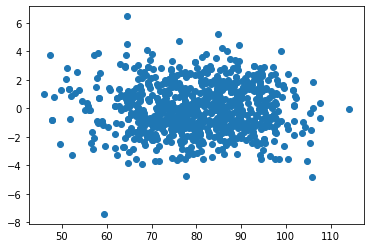

In [2978]:
#A plot of the residuals. There appears to be no pattern to them.

residuals = results.resid

testpredict = results.predict(X)
plt.scatter(testpredict, residuals)

In [2979]:
#Predicting the woin totals of the testing data to see how the model does on "new" data.

Xtest = testingdata[testcolumns.columns]
ytest = testingdata.W
Xtest = sm.add_constant(Xtest)

results.predict(Xtest)

234    88.38596
413    64.96612
244    56.09291
233    86.30479
712    75.19372
         ...   
216    64.27897
692    95.66224
136    93.16211
663    86.95690
92     79.04611
Length: 202, dtype: float64

In [3013]:
#Creating a frame that shows the predicted wins, actual wins, and the difference for the testing data.
#The average difference, highest and lowest differences, are also included.
#The average difference is close to 0, which can be a good sign.
#The max difference is slightly higher than the min difference, implying that the model is slightly more likely to predict high than low. The average difference being positive also suggests this.
#The highest difference is off about 4% (6/162).

testcol = results.predict(Xtest)
testframe = testingdata.W

resultsframe = pd.DataFrame(data = (testcol, testframe))

resultsframe = resultsframe.T

resultsframe.rename({"Unnamed 0":"Predicted Wins", "W":"Actual Wins"}, axis = "columns", inplace = True)

resultsframe["Difference"] = resultsframe["Predicted Wins"] - resultsframe["Actual Wins"]

meandifference = resultsframe.Difference.mean()
maxdifference = resultsframe.Difference.max()
mindifference = resultsframe.Difference.min()

print("The average difference is ",meandifference)
print("The highest difference is ",maxdifference)
print("The lowest difference is ",mindifference)


resultsframe


The average difference is  0.10547548480886601
The highest difference is  6.314668598677045
The lowest difference is  -4.847550787848036


,Predicted Wins,Actual Wins,Difference
234,88.38596,86.0,2.38596
413,64.96612,65.0,-0.03388
244,56.09291,53.0,3.09291
233,86.30479,87.0,-0.69521
712,75.19372,75.0,0.19372
...,...,...,...
216,64.27897,67.0,-2.72103
692,95.66224,95.0,0.66224
136,93.16211,91.0,2.16211
663,86.95690,90.0,-3.04310
